In [1]:
import os
import torch
from torch.autograd import Variable

import time
import scipy.io
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

os.chdir("..")

from Galab import llaplace
from NN import DNN_Ensemble,DNN,Dropout_DNN

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Burgers Equation

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - \frac{0.01}{\pi}\frac{\partial^{2} u}{\partial x^{2}}=0$$
$$u(x,0) = -sin( \pi x),  u(-1,t)=u(1,t)=0$$

In [2]:
def de(self,data_domain):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)
    
    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    f = du[:,1].reshape(-1,1) + u.reshape(-1,1)*du[:,0].reshape(-1,1) - data_domain[:,2].reshape(-1,1)*ddu_x[:,0].reshape(-1,1)

    return f

def ini_c(self,data_inic):
    u = self(data_inic)
    return u + torch.sin(torch.pi*data_inic[:,0].reshape(-1,1))

def left_bc(self,data_lbc):
    u = self(data_lbc)
    return u

def right_bc(self,data_rbc):
    u = self(data_rbc)
    return u

In [3]:
DNN.de = de
DNN.ini_c = ini_c
DNN.left_bc = left_bc
DNN.right_bc = right_bc

In [4]:
def samples_space(size,maxl=1):
    t_f_train = lhs(2, size)*maxl
    t_f_train[:,0] = t_f_train[:,0]*(2)-1
    t_f_train[:,1] = t_f_train[:,1]*(0.5)
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [5]:
def data_pde(size,minp,maxp):

    xy, param = samples_space(size),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xy,param.reshape(-1,1)))).float()
    
    x,y, param  = torch.tensor(xy[:,0]).reshape(-1,1),torch.tensor(xy[:,1]).reshape(-1,1),torch.tensor(param).reshape(-1,1)

    ini_c = torch.cat([x,torch.zeros_like(x).float(),param],axis = 1).float()

    left_bc = torch.cat([torch.ones_like(x).float()*(-1),y, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(x).float(),y, param],axis = 1).float()

    return pde_domain,ini_c,left_bc,right_bc

In [6]:
# Number of observations
nobs = 100
min_param , max_param = 0.0001, 0.05

layers = [3] + 3*[40] + [1]
layers_ensemble = [3] + 3*[40] + [2]

model_1500 = DNN(layers).to(device)
path = f"./AI4Eq/Models/burgers_1500.pt"
model_1500.load_state_dict(torch.load(path))
model_1500.eval()

model_500 = DNN(layers).to(device)
path = f"./AI4Eq/Models/burgers_500.pt"
model_500.load_state_dict(torch.load(path))
model_500.eval()

model_d = Dropout_DNN(layers).to(device)
path = f"./AI4Eq/Models/burgers_mcd.pt"
model_d.load_state_dict(torch.load(path))
model_d.eval()

Dropout_DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=3, out_features=40, bias=True)
    (activation_0): Tanh()
    (dropout_0): Dropout(p=0.5, inplace=False)
    (layer_1): Linear(in_features=40, out_features=40, bias=True)
    (activation_1): Tanh()
    (dropout_1): Dropout(p=0.5, inplace=False)
    (layer_2): Linear(in_features=40, out_features=40, bias=True)
    (activation_2): Tanh()
    (dropout_2): Dropout(p=0.5, inplace=False)
    (layer_3): Linear(in_features=40, out_features=1, bias=True)
  )
)

In [7]:
def ensemble(X_star):
    mean_pred_ensemble,std_pred_ensemble = [],[]

    for n in range(5):
        model = DNN_Ensemble(layers_ensemble).to(device)
        path = f"./AI4Eq/Models/burgers_ensemble_{n}.pt"
        model.load_state_dict(torch.load(path,  map_location=device))
        model.eval()
        pred = model(X_star)
        mean_pred_ensemble.append(pred[:,0].cpu().detach().numpy())
        std_pred_ensemble.append(pred[:,1].cpu().detach().numpy())
        mean = np.mean(np.array(mean_pred_ensemble), axis=0)
        std = np.mean(np.array(std_pred_ensemble) + np.array(mean_pred_ensemble)**2, axis=0)
        std = std-mean**2
    return mean,np.sqrt(std)

def MCD (dropout_model,X_star, samples = 1000):
    dropout_model.train()
    predictions = []

    for _ in range(samples):
        pred = dropout_model(X_star)  # Perform a forward pass with dropout
        predictions.append(pred.cpu().detach().numpy())  # Store the result

    predictions_mcd = np.array(predictions)
    return np.mean(predictions_mcd, axis=0),np.std(predictions_mcd, axis=0)


In [8]:
pde_domain,ini_c,left_bc,right_bc = data_pde(1500,min_param,max_param)

pde = {"PDE":["de","ini_c","left_bc","right_bc"], 
       "data_set":{"de" : Variable(pde_domain,requires_grad=True).to(device),
                   "ini_c" : ini_c.to(device),
                   "left_bc":left_bc.to(device),
                   "right_bc" :right_bc.to(device)}}

llp_1500 = llaplace(model_1500)
llp_1500.fit(pde=pde, hessian_structure = "full")

# log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
# hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
# for i in range(1000):
#     hyper_optimizer.zero_grad()
#     neg_marglik = - llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
#     neg_marglik.backward(retain_graph=True)
#     hyper_optimizer.step()
#     print(log_prior,log_sigma)

In [9]:
pde_domain,ini_c,left_bc,right_bc = data_pde(500,min_param,max_param)

pde = {"PDE":["de","ini_c","left_bc","right_bc"], 
       "data_set":{"de" : Variable(pde_domain,requires_grad=True).to(device),
                   "ini_c" : ini_c.to(device),
                   "left_bc":left_bc.to(device),
                   "right_bc" :right_bc.to(device)}}

llp_500 = llaplace(model_500)
llp_500.fit(pde=pde, hessian_structure = "full")

# log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
# hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
# for i in range(1000):
#     hyper_optimizer.zero_grad()
#     neg_marglik = - llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
#     neg_marglik.backward(retain_graph=True)
#     hyper_optimizer.step()
#     print(log_prior,log_sigma)

In [10]:
time_model1 = {"fit_LAa":[],"fit_LAb_diag":[],"fit_LAb_full":[],"call_LAfull":[],"call_LAdiag":[]}
time_model2 = {"fit_LAa":[],"fit_LAb_diag":[],"fit_LAb_full":[],"call_LAfull":[],"call_LAdiag":[]}

data = scipy.io.loadmat('./AI4Eq/burgers_shock.mat')
y = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

Exact = np.real(data['usol']).T

param_trained =  (0.01/np.pi)

xx, yy = np.meshgrid(x, y)

xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()
X_star = torch.cat([xx,yy,torch.ones_like(xx)*param_trained],axis = 1).to(device)

start = time.time()
f_mu_1500, f_sigma_1500 = llp_1500(X_star)
end = time.time()
f_mu_1500, f_sigma_1500= f_mu_1500.cpu().numpy(), f_sigma_1500.squeeze().sqrt().cpu().numpy()

time_model1["call_LAfull"].append(end- start)

start = time.time()
f_mu_500, f_sigma_500 = llp_500(X_star)
end = time.time()
f_mu_500, f_sigma_500= f_mu_500.cpu().numpy(), f_sigma_500.squeeze().sqrt().cpu().numpy()

time_model2["call_LAfull"].append(end- start)

start = time.time()
f_mu_mcd, f_sigma_mcd =MCD (model_d,X_star)
end = time.time()

start = time.time()
f_mu_ensemble, f_sigma_ensemble = ensemble(X_star)
end = time.time()

xx,yy = np.meshgrid(x, y)

models = {"Dropout":[f_mu_mcd, f_sigma_mcd],"Ensemble":[f_mu_ensemble, f_sigma_ensemble],
          "DeepGaLA\n500obs":[f_mu_500, f_sigma_500],"DeepGaLA\n1500obs":[f_mu_1500, f_sigma_1500]}

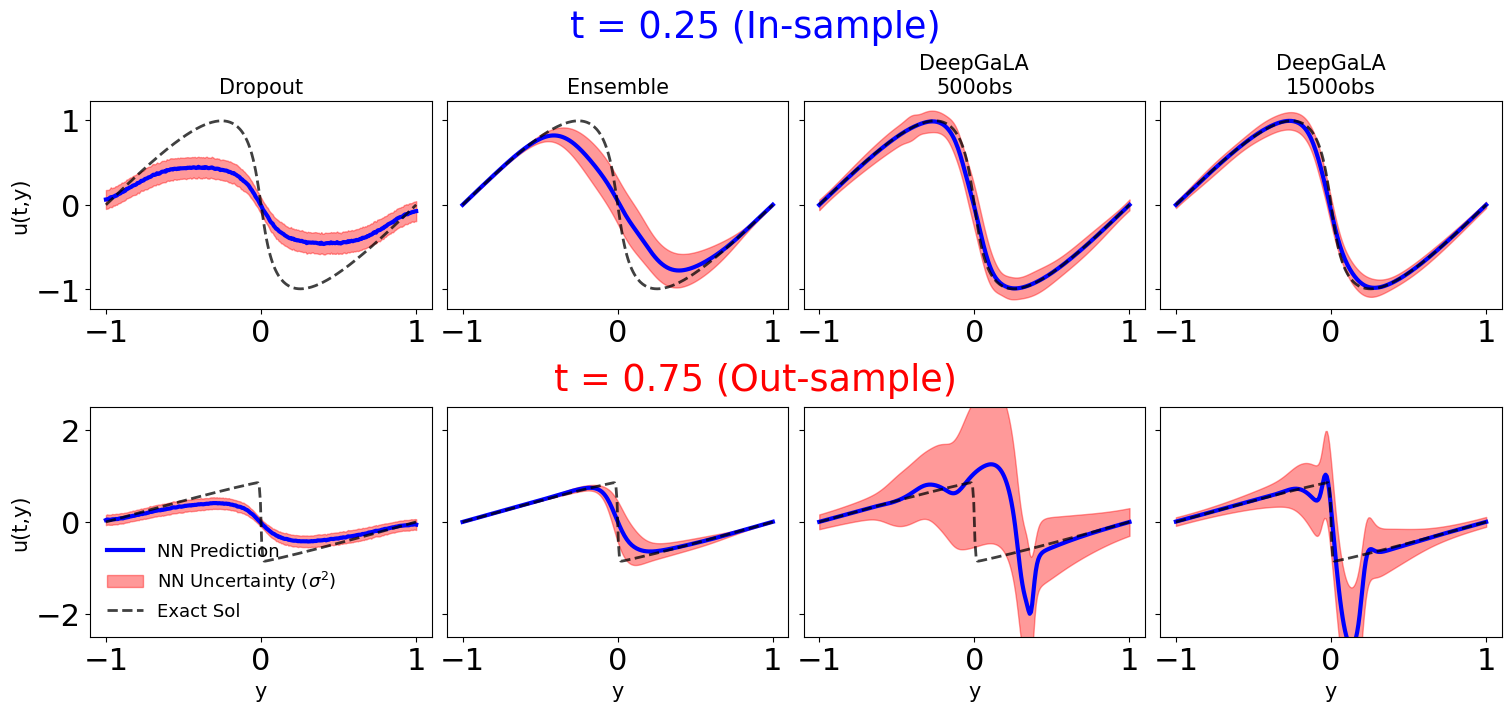

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(15, 7))
(subfig1, subfig2) = fig.subfigures(2, 1) 
ax1 = subfig1.subplots(1, 4, sharey=True,sharex=True)       
ax2 = subfig2.subplots(1, 4, sharey=True,sharex=True) 

#fig, axs = plt.subplots(2, 4, figsize=(14, 6), sharey=True,sharex=True)
plt.rcParams.update({'font.size': 22})

subfig1.suptitle("t = 0.25 (In-sample)",color = "blue")
for i,(ax,model) in enumerate(zip(ax1.flatten(),["Dropout","Ensemble","DeepGaLA\n500obs","DeepGaLA\n1500obs"])):
    t = 25 
    ax.set_title(f"{model}",color = "black", fontsize=15)
    mu, sigma = models[model]

    z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mu.flatten(), (xx,yy), method='cubic')
    z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), sigma.flatten(), (xx,yy), method='cubic')

    ax.plot(x,z_pred[t,:],color = "blue", label = "NN MAP",linewidth=3)
    ax.fill_between(x.reshape(-1), z_pred[t,:]+z_pred_var[t,:],z_pred[t,:]-z_pred_var[t,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    ax.plot(x,Exact[t,:],linestyle = "--",alpha = 0.75,color = "black", label = "Exact Sol",linewidth=2)
ax1[0].set_ylabel(r'u(t,y)',size = 15)

subfig2.suptitle("t = 0.75 (Out-sample)",color = "red")
for i,(ax,model) in enumerate(zip(ax2.flatten(),["Dropout","Ensemble","DeepGaLA\n500obs","DeepGaLA\n1500obs"])):
    t = 75 
    #ax.set_title(f"{model}",color = "black")
    mu, sigma = models[model]

    z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mu.flatten(), (xx,yy), method='cubic')
    z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), sigma.flatten(), (xx,yy), method='cubic')

    ax.plot(x,z_pred[t,:],color = "blue", label = "NN Prediction",linewidth=3)
    ax.fill_between(x.reshape(-1), z_pred[t,:]+z_pred_var[t,:],z_pred[t,:]-z_pred_var[t,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    ax.plot(x,Exact[t,:],linestyle = "--",alpha = 0.75,color = "black", label = "Exact Sol",linewidth=2)
    ax.set_xlabel('y',size = 15)

# axs[1,0].set_ylabel(r'u(y,t)')

# axs[1,0].set_xlabel('x')
# axs[1,1].set_xlabel('x')
ax2[0].set_ylim(-2.5,2.5)

ax2[0].set_ylabel(r'u(t,y)',size = 15)
ax2[0].legend(frameon = False, prop={'size': 13},loc='lower left')
plt.savefig("FullHessian_Burgers.pdf")

In [12]:
# from matplotlib.animation import FuncAnimation, PillowWriter

# fig,ax = plt.subplots(1,2,figsize=(15,5))

# def animate(i):
#     if i > 166:
#         plt.suptitle(f"Observations at time = {i+1}", color = "red")
#     else:
#         plt.suptitle(f"Observations at time = {i+1}")

#     ax[0].clear()
#     ax[1].clear()

#     ax[0].set_title(fr"$\theta$ = $\pi/0.1$")
#     ax[0].set_xlabel("x")
#     ax[0].set_ylabel(fr"N(x,t={i+1}; $\theta$)")
#     ax[0].set_ylim((-1.5,1.5))
#     ax[0].set_xlim((-1,1))

#     ax[1].set_title(fr"$\theta$ = 0.6")
#     ax[1].set_xlabel("x")
#     ax[1].set_ylim((-1.5,1.5))
#     ax[1].set_xlim((-1,1))

#     img1 = ax[0].plot(x,z_pred1[i,:],color = "blue")
#     img2 = ax[0].fill_between(x.reshape(-1), z_pred1[i,:]+2*z_pred_var1[i,:],z_pred1[i,:]-2*z_pred_var1[i,:],alpha=0.4, color = "red")

#     img3 = ax[1].plot(x,z_pred2[i,:],color = "blue")
#     img4 = ax[1].fill_between(x.reshape(-1), z_pred2[i,:]+2*z_pred_var2[i,:],z_pred2[i,:]-2*z_pred_var2[i,:],alpha=0.4, color = "red")

#     return img1,img2,img3,img4

# ani = FuncAnimation(fig, animate, interval=5, blit=False, repeat=True, frames=250)    
# ani.save("TLIb.gif", dpi=300, writer=PillowWriter(fps=25))